# Chapter 3: Classification

In [41]:
# Ignore Scikit-learn Future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
# Keep same ordering as from book
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

In [42]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


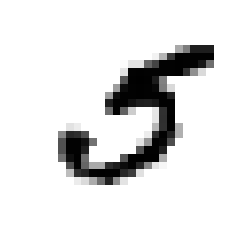

In [43]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
           interpolation='nearest')
plt.axis('off')
plt.show()

Notice that our `some_digit` variable is a 5. We will use this later to see if our model can correctly predict that this image is an image of a 5.

In [44]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

In [45]:
shuffle_index = np.random.permutation(60_000)
X_train, y_train = X[shuffle_index], y[shuffle_index]

In [46]:
y_train_5, y_test_5 = (y_train == 5), (y_test == 5)

In [47]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Note that our SGD Classifier correctly predicts that `some_digit` is a 5!

In [48]:
sgd_clf.predict([some_digit])

array([ True])

### Cross Validation

In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
print(n_correct / len(y_pred))

0.9192


In [50]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.94005, 0.8896 , 0.9192 ])

The results above shouldn't be seen as too impressive! If we predict that a number is never 5 (and we assume that the number of numbers in the dataset is equally distributed - that is 10% of the numbers are 5's), then we would get the answer right 90% of the time. While ~96% is somewhat better than just guessing, it may not be as good as it sounds...

In [51]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[50121,  4458],
       [  565,  4856]])

##### Confusion Matrix
-----------------
| - | Is not 5 | Is 5 |
|---------------------|----------|------|
| Identified as not 5 | $TN$: <span style="background-color:green;">54098</span>        | $FN$: <span style="background-color:red;">481</span>    |
| Identified as 5     | $FP$: <span style="background-color:red;">1788</span>        | $TP$: <span style="background-color:green;">3633</span>    |

##### Definitions:
$TP$ = True Positive (Identified as 5 and is a 5)  
$FP$ = False Positive (Identified as 5 and not a 5)  
$FN$ = False Negative (Identified as not a 5 and is a 5)  

---
##### Equations:
precision = $\frac{TP}{TP + FP}$  = $\frac{\text{Correctly identified as a 5}}{\text{Total # of images identified as 5's}}$  
recall = $\frac{TP}{TP + FN}$ = $\frac{\text{Correctly identified as 5}}{\text{Total # of actual 5's}}$

In [53]:
from sklearn.metrics import precision_score, recall_score
print("Precision score:", precision_score(y_train_5, y_train_pred))
print("Recall score:", recall_score(y_train_5, y_train_pred))

Precision score: 0.5213656860639897
Recall score: 0.8957756871425936


##### $F_{1}$ Score

---
$F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$  
  
  

*In order for a $F_{1}$ score to be high, both recall and precision must be high. Therefore, a high $F_{1}$ score is good.*  
However, you can't improve both precision and recall. This is called the **precision/recall tradeoff**.

In [54]:
# Sklearn has a built in f1 score function
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.6591109602986087

In [55]:
y_scores = sgd_clf.decision_function([some_digit])
print("Y scores:", y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print("Y some digit prediction is",y_some_digit_pred)

Y scores: [94244.91361684]
Y some digit prediction is [ True]


Changing the threshold can result in a different prediction

In [56]:
threshold = 200_000
y_some_digit_pred = (y_scores > threshold)
print("Y some digit prediction is", y_some_digit_pred)

Y some digit prediction is [False]


In [57]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
print(y_scores)

[-212822.96816268  -71422.11542212   51326.9529812  ... -705696.1076116
   55442.30601235 -465578.39558319]


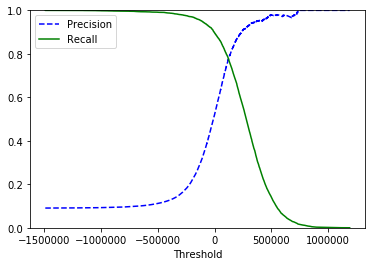

In [58]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

##### Definitions:

---
**False Positive Rate**: Ratio of negative instances that are classified as positive to total number of negative instances  
  
  
**True Negative Rate**: Ratio of positive instances that are classified as negative to total number of positive instances  
  
  
**Receiver Operating Characteristic (ROC) curve**: Plots *sensitivity* (recall) vs. 1 - *specificity* (TNR)

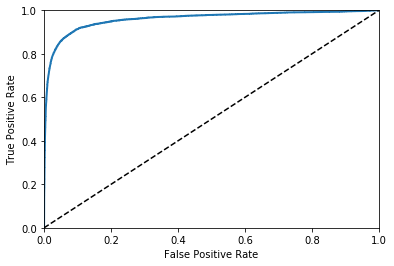

In [59]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

The ROC curve of a purely random classifier is shown with the black dotted line in the figure above. We want to choose a recall and precision that is as far from that line as possible.

In [60]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9596793802838739

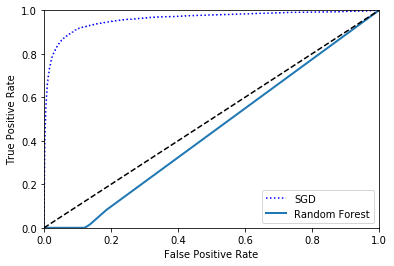

In [61]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [62]:
roc_auc_score(y_train_5, y_scores_forest)

0.4429047724532153

### Multiclass Classification

---
*Binary classifiers* distinguish two classes while *multiclass (or multinomial) classifiers* can distinguish between more than 2 classes.  
  
  
Using binary classifiers, we can make a binary classifier for each value we want to test (ex: numbers 0-9) and then test an object (picture of a number) against each possible value (ex: test for each number; run 10 tests). Then, we return the test which scores the highest. This is called **one-versus-all(OvA)** (or also **one-versus-the-rest**).  
  
  
Another possibility is to make every possible combination of binary tests for two objects (ex: 0 vs. 1, 0 vs. 2, ...) and then run each test and see which scores the highest. This is called the **one-versus-one (OvO)** strategy. This way you don't have to have such large training set since your training data will only have inputs comparing two values (ex: probably only 20% of the data will be 0's and 1's - assuming each number is equally likely to appear).  
  
  
This can be better for some algorithms (SVM classifiers) that scale poorly with size of the training set. However, for most binary classification algorithms, OvA is preferred.  
  
  
Ex: We have 3 of each digit (0-9). If we do the OvA, then we have to run 10 tests. That means we have to train on $30 \cdot 10$ (number of rows to train on * number of classifications). If we use OvO, then we will need to train $\frac{n(n-1)}{2} = 45$ different sets and each set will have 6 rows. Therefore, it will take $45 \cdot 6$ rows to train on. This can vary, however, based on what the setup looks like. 

In [63]:
sgd_clf.fit(X_train, y_train)
print("Prediction:", sgd_clf.predict([some_digit]))

Prediction: [3]


In [64]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -88964.76408186, -529343.36349801, -462599.45880186,
         117998.22497578, -317062.96149692,   94244.91361684,
        -794293.92112   , -393352.86185417, -619323.37268268,
        -573571.42641021]])

In [65]:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[5])

3
[0 1 2 3 4 5 6 7 8 9]
5


In [66]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)